# HW-Anomaly Detection

### Table of content

* <a href="#Imports">Imports</a>
* <a href="#Preprocessing">Preprocessing</a>
* <a href="#Algorithm">Algorithm</a>
* <a href="#Sensetivity-analysis">Sensetivity analysis</a>
* <a href="#Graphs">Graphs</a>

### Import

In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import seaborn as sns
sns.set()
from pylab import rcParams
from sklearn.cluster import KMeans

%matplotlib inline

### Preprocessing

**Reading csv and checking the dataframe**

In [335]:
df = pd.read_csv('data.csv')
df.head(3)

,length,width
0,9.608133,15.392309
1,29.071571,30.221158
2,10.455726,21.578669


In [336]:
df.columns

Index(['length ', 'width'], dtype='object')

<br>

**There is a space character in the end of column name 'length ', we'll rename it**

In [337]:
df.rename(columns = {'length ': 'length'}, inplace = True)

In [338]:
df.columns

Index(['length', 'width'], dtype='object')

<br>

**Check for NaN values**

In [339]:
df.isna().sum()

length    0
width     0
dtype: int64

<br>

**Preview data**

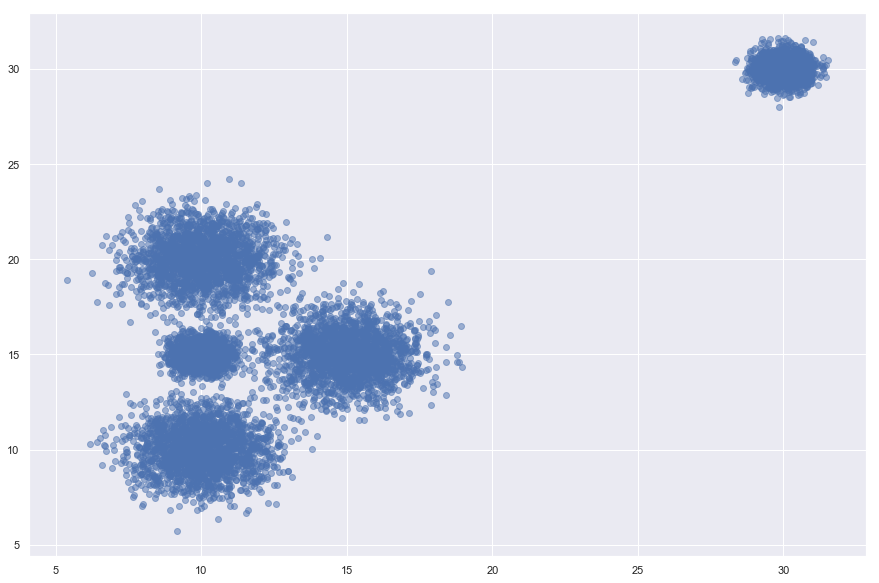

In [413]:
plt.scatter(df["length"],df["width"], alpha = 0.5)
rcParams['figure.figsize'] = 15,10

<br>

### Algorithm

In [343]:
kmeans = KMeans(n_clusters=5, random_state = 23)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=23, tol=0.0001, verbose=0)

<br>

**Centroids**

In [344]:
kmeans.cluster_centers_

array([[10.05301592, 15.00944162],
       [29.99613301, 30.0041642 ],
       [15.07639641, 14.99321007],
       [10.01220952, 20.08115227],
       [10.02593659,  9.96595602]])

<br>

**Labels**

In [349]:
kmeans.labels_

array([0, 1, 3, ..., 1, 2, 1], dtype=int32)

<br>

**Adding label column to dataframe**

In [350]:
df['label'] = kmeans.labels_

In [351]:
df.head(3)

,length,width,label
0,9.608133,15.392309,0
1,29.071571,30.221158,1
2,10.455726,21.578669,3


<br>

**Function for calculating distance of point to it's centroid using <font color='green'>np.linalg.norm<font/>** <br>
This works because Euclidean distance is l2 norm and the default value of ord parameter in numpy.linalg.norm is 2

In [352]:
def OutlierDetection(row, threshold = 3):
    point = np.array(row[:2])
    centroid = kmeans.cluster_centers_[int(row[2])]
    if np.linalg.norm(centroid - point) > threshold:
        row['outlier'] = 1
    else:
        row['outlier'] = 0
    return row

<br>

**Applying function to each row and adding outlier column with binary values ( 1 - for outlier, 0 - for not )**

In [353]:
df = df.apply(OutlierDetection, axis=1)

In [354]:
df[df['outlier'] == 1].head(3)

,length,width,label,outlier
30,13.797117,20.011291,3.0,1.0
46,6.711448,21.202205,3.0,1.0
111,17.969779,16.386521,2.0,1.0


<br>

**Converting label and outlier columns from float type to int**

In [418]:
df = df.astype({'label': int, 'outlier': int})

In [419]:
df.head()

,length,width,label,outlier
0,9.608133,15.392309,0,0
1,29.071571,30.221158,1,0
2,10.455726,21.578669,3,0
3,30.004273,29.920632,1,0
4,9.067346,22.520767,3,0


**Writing dataframe to csv file**

In [420]:
df.to_csv('anomaly detection.csv',index = False, header = True);

### Sensetivity analysis

In [358]:
df_copy = df.copy()

In [359]:
df_copy.head()

,length,width,label,outlier
0,9.608133,15.392309,0.0,0.0
1,29.071571,30.221158,1.0,0.0
2,10.455726,21.578669,3.0,0.0
3,30.004273,29.920632,1.0,0.0
4,9.067346,22.520767,3.0,0.0


**Running few thresholds to check how proportion of defected desks changes**

In [410]:
thresholds = np.arange(0.5, 6, 0.5)
defects_proportion = []

for threshold in thresholds:
    df_copy = df_copy.apply(OutlierDetection,threshold = threshold, axis=1)
    defects_proportion.append(df_copy['outlier'].sum()/df_copy.shape[0])

### Graphs

**Clustered desks with their centroids**

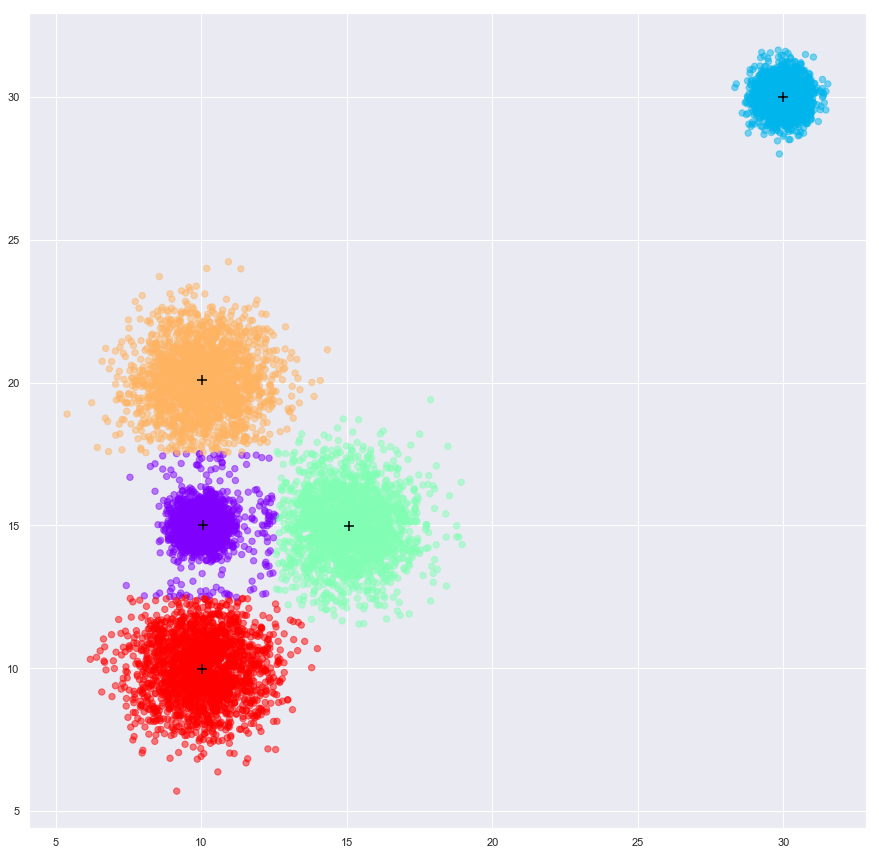

In [356]:
plt.scatter(df['length'],df['width'], c=kmeans.labels_, cmap='rainbow', s = 40, marker = 'o',alpha = 0.5);
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black', marker = '+', s = 100)
rcParams['figure.figsize'] = 15,15

**Defected desks ( threshold = 3 cm from it's centroid )**

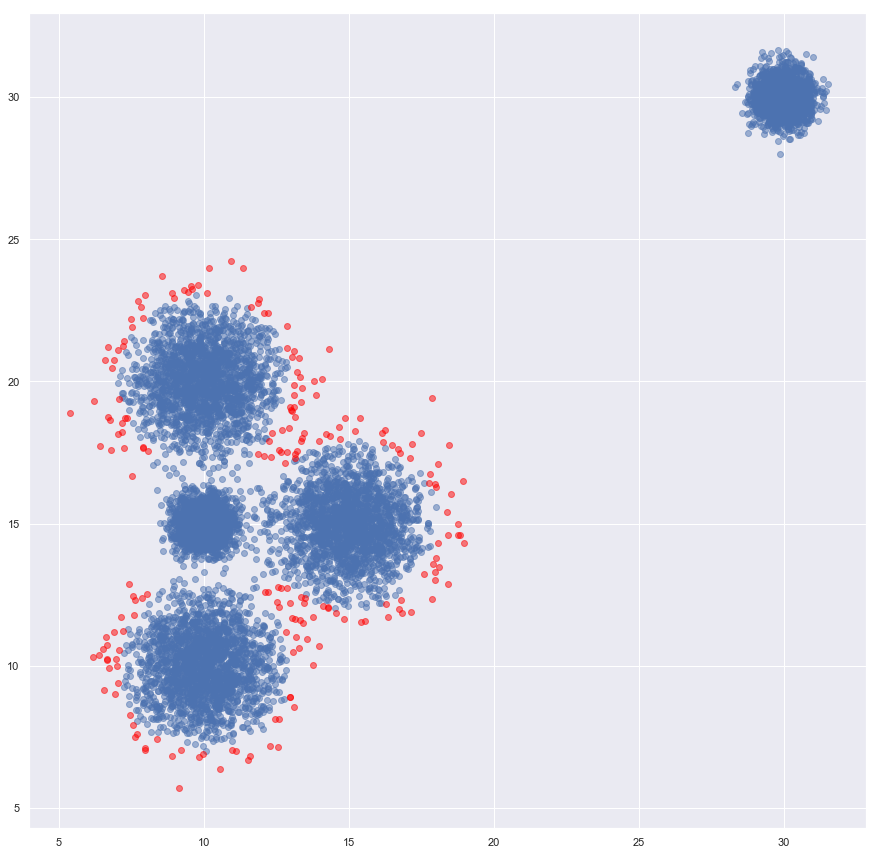

In [357]:
plt.scatter(df["length"][df['outlier']==0],df["width"][df['outlier']==0], alpha = 0.5)
plt.scatter(df["length"][df['outlier']==1],df["width"][df['outlier']==1], color='red', alpha = 0.5)
rcParams['figure.figsize'] = 15,15

**Proportion of defected desks by threshold**

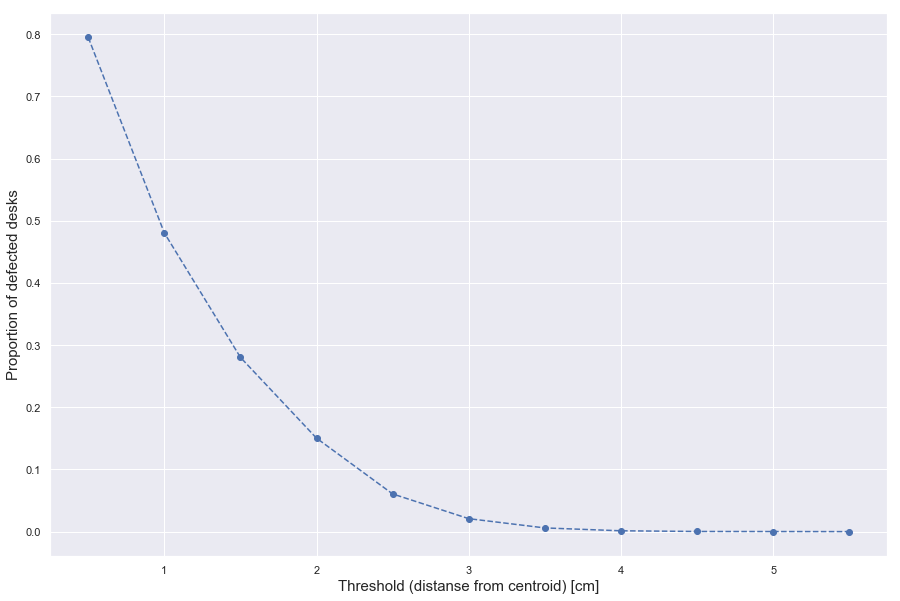

In [412]:
plt.plot(thresholds,defects_proportion, '--bo')
rcParams['figure.figsize'] = 15,10
plt.xlabel('Threshold (distanse from centroid) [cm]',fontsize=15)
plt.ylabel('Proportion of defected desks',fontsize=15)
plt.show()